In [71]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
from sklearn.metrics import classification_report

In [162]:
batch_size = 1
num_classes = 5
img_height = 50
img_width = 50

In [163]:
train = tf.keras.preprocessing.image_dataset_from_directory(
  '../../../data/raw/eye_frames/50_50/',
  validation_split=0.1,
    color_mode="grayscale",
    label_mode='int',
  subset="training",
    shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

dev = tf.keras.preprocessing.image_dataset_from_directory(
  '../../../data/raw/eye_frames/50_50/',
  validation_split=0.1,
  color_mode="grayscale",
    label_mode='int',
    shuffle=True,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test = tf.keras.preprocessing.image_dataset_from_directory(
  '../../../data/raw/eye_frames/testing_50_50/',
  color_mode="grayscale",
    label_mode='int',
    shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train.class_names
print(class_names)

Found 15252 files belonging to 5 classes.
Using 13727 files for training.
Found 15252 files belonging to 5 classes.
Using 1525 files for validation.
Found 1372 files belonging to 5 classes.
['center', 'down', 'left', 'right', 'up']


In [85]:
input_layer = keras.Input(shape=(img_height, img_width, 1))
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)
x = keras.layers.Conv2D(32, 1, padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(64, 1, padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(128, 1, padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
# x = keras.layers.Dense(32, activation='relu')(x)
output_layer = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer, name="jupiter3")

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
# opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
model.compile(optimizer=opt, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
   
model.summary()

Model: "jupiter3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 64)        2112      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)       832

In [86]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = tf.keras.callbacks.ModelCheckpoint('./best_model_aug.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks = [es,mc]

In [82]:
epochs = 50

In [87]:
history = model.fit(
  train,
  validation_data=dev,
  epochs=epochs, 
  batch_size =batch_size,
    callbacks=callbacks
)

Epoch 1/50
429/429 [==============================] - ETA: 0s - loss: 1.1927 - accuracy: 0.7161
Epoch 00001: val_accuracy improved from -inf to 0.89770, saving model to ./best_model_aug.h5
429/429 [==============================] - 15s 35ms/step - loss: 1.1927 - accuracy: 0.7161 - val_loss: 1.0109 - val_accuracy: 0.8977
Epoch 2/50
429/429 [==============================] - ETA: 0s - loss: 1.0062 - accuracy: 0.9014
Epoch 00002: val_accuracy improved from 0.89770 to 0.92393, saving model to ./best_model_aug.h5
429/429 [==============================] - 15s 34ms/step - loss: 1.0062 - accuracy: 0.9014 - val_loss: 0.9837 - val_accuracy: 0.9239
Epoch 3/50
428/429 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.9170
Epoch 00003: val_accuracy improved from 0.92393 to 0.93574, saving model to ./best_model_aug.h5
429/429 [==============================] - 15s 34ms/step - loss: 0.9885 - accuracy: 0.9172 - val_loss: 0.9719 - val_accuracy: 0.9357
Epoch 4/50
429/429 [========

In [88]:
train_history = pd.DataFrame(history.history)

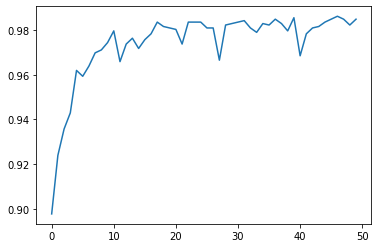

In [91]:
train_history.val_accuracy.plot()

In [491]:
def augment(arr):
    for idx in range(len(arr)):
        img = arr[idx]
        img = np.array(tf.image.random_brightness(img,max_delta=0.3))
        while (img.mean() > 210) or (img.mean() < 50):
            img = np.array(tf.image.random_brightness(img,max_delta=0.3))
        arr[idx] = img
    return arr

In [492]:
path = '../../../data/raw/eye_frames/testing_50_50/'
d = {}
for idx, l in enumerate(['center', 'down', 'left', 'right', 'up']):
    subpath = os.path.join(path, l)
    files = glob.glob(subpath + '/*.jpg')
    data = []
    for f in files:
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        data.append(img)
    d[idx] = np.array(data)
shapes = {key:val.shape[0] for key,val in d.items()}
max_size = max(shapes.values())
print(shapes)

{0: 356, 1: 258, 2: 268, 3: 414, 4: 76}


In [493]:
for key, val in shapes.items():
    diff = max_size - val
    if diff <= 0:
        continue
    else:
        smpl_idxs = np.random.randint(0, val-1, size=diff)
        samples = augment(d[key][smpl_idxs])
        d[key] = np.concatenate([d[key],samples])
shapes = {key:val.shape[0] for key,val in d.items()}
print(shapes)


{0: 414, 1: 414, 2: 414, 3: 414, 4: 414}


In [494]:
# for key, val in shapes.items():
#     diff = max_size - val
#     if diff <= 0:
#         continue
#     else:
#         smpl_idxs = np.random.randint(0, val-1, size=diff)
#         samples = d[key][smpl_idxs]
#         d[key] = np.concatenate([d[key],samples])
# shapes = {key:val.shape[0] for key,val in d.items()}
# print(shapes)


In [495]:
# double up
d[0] = np.concatenate([d[0],d[0]])
d[1] = np.concatenate([d[1],d[1]])
d[2] = np.concatenate([d[2],d[2]])
d[3] = np.concatenate([d[3],d[3]])
d[4] = np.concatenate([d[4],d[4]])
shapes = {key:val.shape[0] for key,val in d.items()}
print(shapes)

{0: 828, 1: 828, 2: 828, 3: 828, 4: 828}


In [496]:
images = []
labels = []
for key, val in d.items():
    images.extend(list(val))
    labels.extend([key]*len(val))
images = np.array(images)
labels = np.array(labels)

In [504]:
jupiter = tf.keras.models.load_model('../models/jupiter3.h5')
jupiter.evaluate(x=images,y=labels)

130/130 [==============================] - 1s 11ms/step - loss: 1.4045 - accuracy: 0.2164


[1.40449857711792, 0.2164251208305359]

In [507]:
for i in range(len(jupiter.layers)):
    jupiter.layers[i].trainable = False
jupiter.layers[-1].trainable = True

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')

jupiter.compile(optimizer=opt, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mc = tf.keras.callbacks.ModelCheckpoint('./tuned.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)
callbacks = [es,mc]

Epoch 1/20
4139/4140 [============================>.] - ETA: 0s - loss: 1.2875 - accuracy: 0.6125
Epoch 00001: accuracy improved from -inf to 0.61256, saving model to ./tuned.h5
4140/4140 [==============================] - 4s 1ms/step - loss: 1.2874 - accuracy: 0.6126
Epoch 2/20
4122/4140 [============================>.] - ETA: 0s - loss: 1.2605 - accuracy: 0.6405
Epoch 00002: accuracy improved from 0.61256 to 0.64034, saving model to ./tuned.h5
4140/4140 [==============================] - 4s 1ms/step - loss: 1.2606 - accuracy: 0.6403
Epoch 3/20
4126/4140 [============================>.] - ETA: 0s - loss: 1.2378 - accuracy: 0.6653
Epoch 00003: accuracy improved from 0.64034 to 0.66570, saving model to ./tuned.h5
4140/4140 [==============================] - 4s 1ms/step - loss: 1.2374 - accuracy: 0.6657
Epoch 4/20
4105/4140 [============================>.] - ETA: 0s - loss: 1.2394 - accuracy: 0.6636
Epoch 00004: accuracy did not improve from 0.66570
4140/4140 [===========================

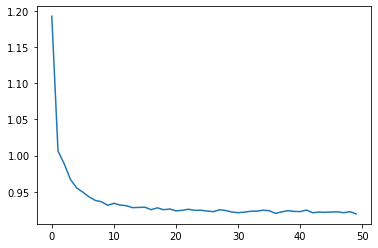

In [508]:
retrain_history = jupiter.fit(
x= images,
    y=labels,
  epochs=20, 
  batch_size =1,
    callbacks=callbacks
)
train_history = pd.DataFrame(history.history)
train_history.loss.plot()

In [509]:
jupiter.evaluate(x=images,y=labels)

130/130 [==============================] - 1s 11ms/step - loss: 1.1863 - accuracy: 0.7179


[1.1862579584121704, 0.7178744077682495]

In [510]:
predictions = jupiter.predict(images)
predictions =[i.argmax() for i in predictions]
report = classification_report(labels,predictions, output_dict=True)
report= pd.DataFrame(report).transpose()
scores = report['f1-score'].iloc[0:5]
scores = {int(i):j for i,j in zip(scores.index,scores.values)}
print(scores)

In [546]:
retrain_history = jupiter.fit(
x= d[0],
    y=np.array([0]*len(d[0])),
  epochs=20, 
  batch_size =1,
    callbacks=callbacks
)

Epoch 1/20
824/828 [============================>.] - ETA: 0s - loss: 1.4362 - accuracy: 0.4660
Epoch 00001: accuracy did not improve from 0.72440
828/828 [==============================] - 1s 1ms/step - loss: 1.4348 - accuracy: 0.4674
Epoch 2/20
801/828 [============================>.] - ETA: 0s - loss: 1.3825 - accuracy: 0.5218
Epoch 00002: accuracy did not improve from 0.72440
828/828 [==============================] - 1s 1ms/step - loss: 1.3777 - accuracy: 0.5266
Epoch 3/20
800/828 [===========================>..] - ETA: 0s - loss: 1.3513 - accuracy: 0.5525
Epoch 00003: accuracy did not improve from 0.72440
828/828 [==============================] - 1s 1ms/step - loss: 1.3458 - accuracy: 0.5580
Epoch 4/20
784/828 [===========================>..] - ETA: 0s - loss: 1.1369 - accuracy: 0.7666
Epoch 00004: accuracy improved from 0.72440 to 0.76932, saving model to ./tuned.h5
828/828 [==============================] - 1s 1ms/step - loss: 1.1341 - accuracy: 0.7693
Epoch 5/20
797/828 [====

In [549]:
print(scores)

{0: 0.3246268656716418, 1: 0.7130620985010706, 2: 0.9076517150395778, 3: 0.7360157016683024, 4: 0.7771556550951848}


In [550]:
predictions = jupiter.predict(images)
predictions =[i.argmax() for i in predictions]
report = classification_report(labels,predictions, output_dict=True)
report= pd.DataFrame(report).transpose()
scores = report['f1-score'].iloc[0:5]
scores = {int(i):j for i,j in zip(scores.index,scores.values)}
print(scores)

{0: 0.36990595611285265, 1: 0.004807692307692307, 2: 0.5479930191972078, 3: 0.0, 4: 0.014354066985645932}


In [513]:
print(report)

              precision    recall  f1-score   support

           0       0.71      0.21      0.32       828
           1       0.64      0.80      0.71       828
           2       1.00      0.83      0.91       828
           3       0.62      0.91      0.74       828
           4       0.72      0.84      0.78       828

    accuracy                           0.72      4140
   macro avg       0.74      0.72      0.69      4140
weighted avg       0.74      0.72      0.69      4140



In [422]:
print(report)

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       828
           1       0.56      0.93      0.70       414
           2       1.00      0.98      0.99       414
           3       0.42      0.46      0.44       414
           4       0.99      0.52      0.68       414

    accuracy                           0.67      2484
   macro avg       0.72      0.69      0.68      2484
weighted avg       0.71      0.67      0.67      2484



In [215]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.52      0.63      1780
           1       0.71      0.92      0.81      1290
           2       0.97      0.98      0.97      1340
           3       0.76      0.91      0.83      2070
           4       1.00      0.55      0.71       380

    accuracy                           0.81      6860
   macro avg       0.85      0.78      0.79      6860
weighted avg       0.82      0.81      0.80      6860



In [199]:
test.class_names

['center', 'down', 'left', 'right', 'up']

In [67]:
from sklearn import metrics

In [69]:
metrics.accuracy_score(test_labels, predictions)

0.4803206997084548

In [46]:
test_images.shape

(1372, 50, 50, 1)

In [107]:
base_model = tf.keras.models.load_model('./best_model_aug.h5')

In [108]:
base_model.evaluate(val_ds)

143/143 [==============================] - 1s 6ms/step - loss: 0.9311 - accuracy: 0.1825


[0.9311159253120422, 0.18251365423202515]

In [54]:
def load_dataset(basepath):
    data = []
    labels = []
    for label in ['up','down','left','right','center']:
        files = glob.glob(os.path.join(basepath,label) + '/*.jpg')
        for f in files:
            img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
            img = img.reshape((50,50,1))
#             img = np.expand_dims(img,0)
            data.append(img)
            labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    print('loading complete.')
    return data, labels

In [55]:
X, y = load_dataset(basepath='../../../data/raw/eye_frames/')

loading complete.


In [56]:
X.shape

(15252, 50, 50, 1)

In [57]:
le = preprocessing.LabelEncoder()

In [58]:
y_encoded = le.fit_transform(y)

In [59]:
le.classes_

array(['center', 'down', 'left', 'right', 'up'], dtype='<U6')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, shuffle=True)